# Click Throughs
Will they click our ad?

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use classification models to make click-through predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#display all columns and rows for DataFrames
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

#import my personal modules created for this report
import wrangle as w
import explore as e
import model as m

## Acquire

* Data acquired from interviewquery github on December 12, 2022.
* It contained 600000 rows and 24 columns
* Each observation represents an instance of an online advertisement
* Each column represents a feature of those visits

In [2]:
#import train and test data sets from interviewquery github
unclean_click_through_data = w.acquire_click_through_data()

## Prepare
* Checked for nulls, there were none
* Changed the ```hour``` column to datetime
* Created columns ```hour_of_day``` and ```day_of_week``` based on ```hour``` column
* Split data into train, validate, and test (65/20/15)

In [3]:
#prep data
click_through_data = w.prep_data(unclean_click_through_data)

In [4]:
#split data
train, validate, test = w.split_data(click_through_data)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**id**| Advertisement instance unique id | *int*|
| **hour** | The date and hour of day |*datetime*|
| **C1** | Anonymized categorical variable |*int*|
|**banner_pos**| Location of ad on the page | *int*|
|**hour_of_day**| Hour of the day when the ad was displayed | *str*|
|**day_of_week**| Day of the week when the ad was displayed | *str*|
|**C14-C21**|Anonymized continuous variables | *int*|
|**Target variable**
|**click**| Did they click? (1-Yes, 0-No) | *int* |

### A look at the data

In [5]:
#show the first few rows of the train data
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
366134,2009636145773373157,0,2014-10-27 16:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b21ff9ff,8a4875bd,1,0,15701,320,50,1722,0,35,-1,79,16,Monday
95054,17172250707259950008,0,2014-10-24 06:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,c2c5a1d7,553f099b,1,0,21762,320,50,2502,0,39,-1,221,6,Friday
189299,2922056073063093914,0,2014-10-25 13:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,8ded1f7a,a99f214a,151a3c3c,81b42528,1,0,15706,320,50,1722,0,35,100083,79,13,Saturday
569650,4743847194723927815,0,2014-10-29 14:00:00,1010,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,0f2161f8,ae592d11,ad732444,8ff0f4af,4,0,23822,320,50,2728,0,290,-1,42,14,Wednesday
581283,218700043766238420,1,2014-10-29 17:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,0d936d2a,909d8f37,1,0,17614,320,50,1993,2,1063,100084,33,17,Wednesday


## Explore

### 1. What percentage of visits resulted in a click-through?

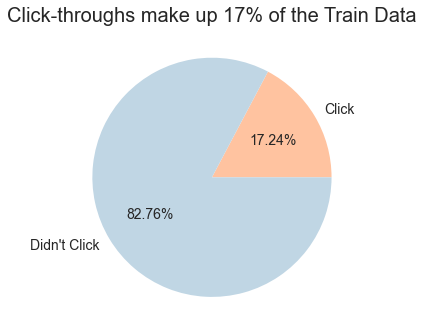

In [6]:
#show percentage of clicks
e.click_percentage(train)

### 2. Does the hour of the day have an impact of click-throughs?

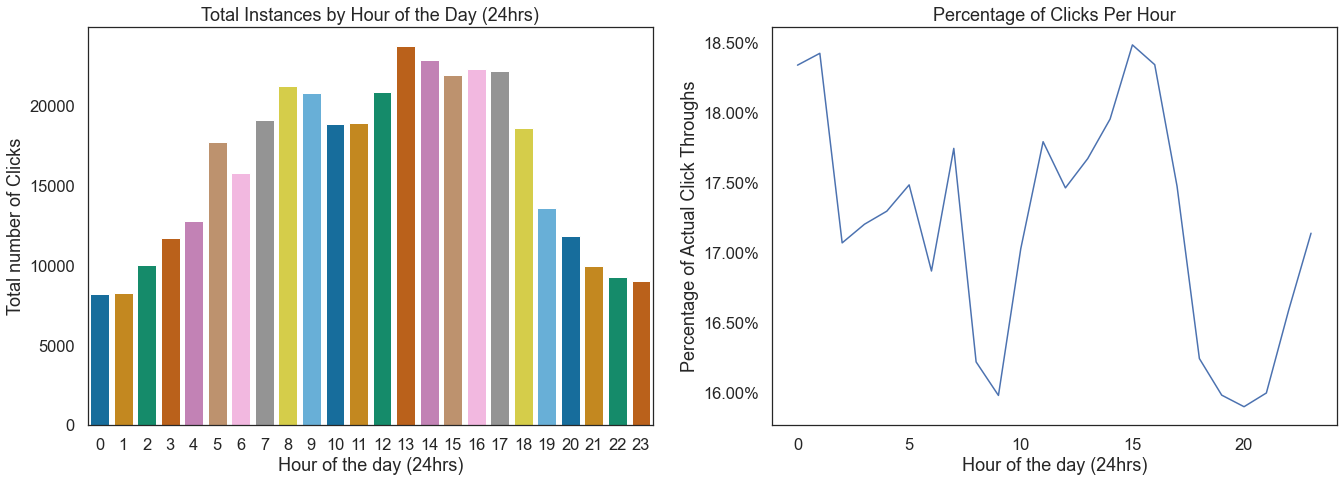

In [7]:
#show hour of day visualizations
e.hour_click_through_viz(train)

**It looks like there are more click throughs per instance at 1 am and 3 pm (15).** 

***Let's do a $\chi^2$ to see if there is a relationship***

**Set Hypothesis**

$H_0$ = There is no relationship between each ```hour_of_day``` and ```click```.

$H_a$ = There is a relationship between each ```hour_of_day``` and ```click```.

In [8]:
#χ^2 test results
e.chi_square_matrix(train, 'hour_of_day', 'click').T

hour_of_day,15,9,16,8,19,20,18,21,14,1,0,11,7,13,22,6,17,5,12,10,2,23,4,3
χ^2,2.497403e+01,2.449448e+01,19.948293,16.443461,15.645811,15.374762,13.647408,10.994026,8.531434,8.129003,6.936594,4.153922,3.490100,3.218827,2.792559,1.592921,0.855082,0.733638,0.722513,0.628886,0.206261,0.064111,0.021792,0.011356
p-value,5.810768e-07,7.452317e-07,0.000008,0.000050,0.000076,0.000088,0.000221,0.000914,0.003491,0.004356,0.008445,0.041538,0.061737,0.072796,0.094703,0.206909,0.355119,0.391707,0.395321,0.427764,0.649714,0.800112,0.882641,0.915134


**p < alpha for ```hour_of_day``` (0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21) so we can reject the null hypothesis for those hours and say there is probably a relationship between those hours and ```clicks```**

## 3. Does the day of the week have an impact on click-throughs?

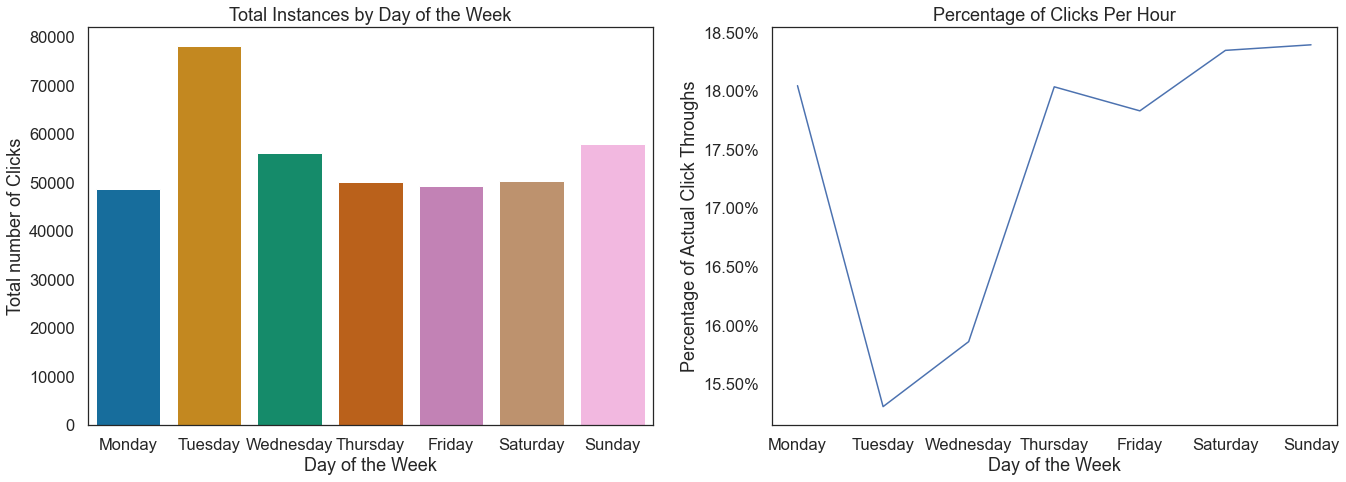

In [9]:
#show day of week visualizations
e.day_click_through_viz(train)

**Set Hypothesis**

$H_0$ = There is no relationship between each ```day_of_week``` and ```click```.

$H_a$ = There is a relationship between each ```day_of_week``` and ```click```.

In [10]:
#χ^2 test results
e.chi_square_matrix(train, 'day_of_week', 'click').T

day_of_week,Tuesday,Wednesday,Sunday,Saturday,Thursday,Monday,Friday
χ^2,2.566100e+02,8.757692e+01,6.254052e+01,4.880185e+01,2.508734e+01,2.481971e+01,13.459815
p-value,9.407334e-58,8.106500e-21,2.610182e-15,2.831728e-12,5.479151e-07,6.295061e-07,0.000244


**p < alpha for every day of the week, so we can reject the null hypothesis and say there is probably a relationship between every ```day_of_week``` and ```click```.** 

## 4. Does banner position have an impact click-throughs?

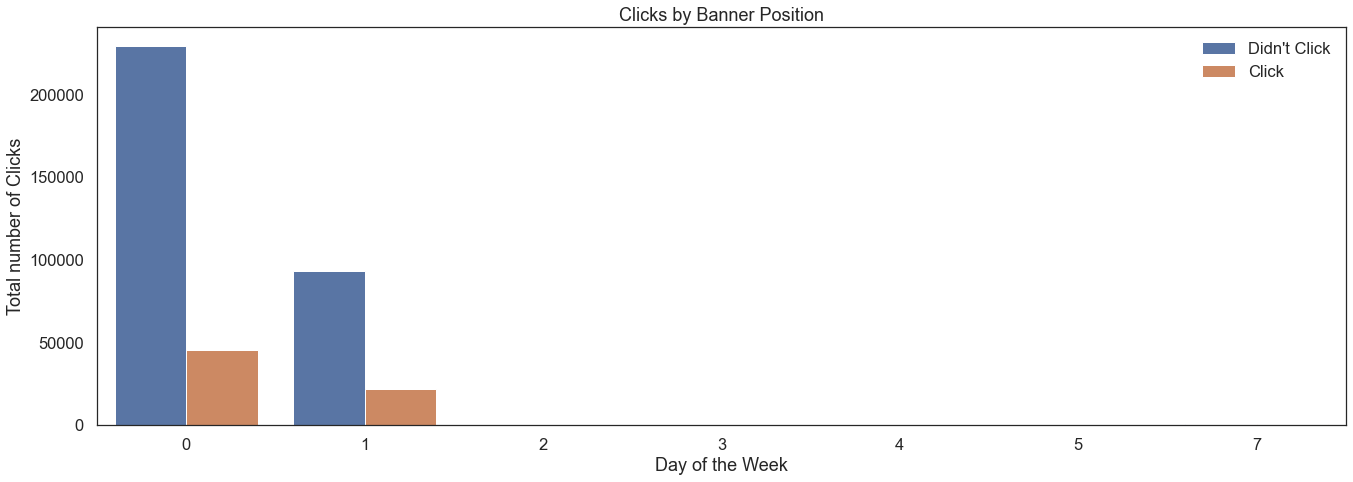

In [11]:
#Clicks vs. didn't click for each banner position
e.banner_pos_viz(train)

**Set Hypothesis**

$H_0$ = There is no association between each ```banner_pos``` and ```click```.

$H_a$ = There is a association between each ```banner_pos``` and ```click```.

In [12]:
#χ^2 test results
e.chi_square_matrix(train, 'banner_pos', 'click').T

banner_pos,0,1,7,2,3,5,4
χ^2,4.192313e+02,3.973823e+02,7.211736e+01,8.486756,0.342021,0.184251,0.036154
p-value,3.587228e-93,2.045372e-88,2.027724e-17,0.003577,0.558665,0.667745,0.849197


**p < alpha for ```banner_pos``` (0, 1, 2, 7), so we can reject the null hypothesis and say there is probably a relationship between ```banner_pos``` (0, 1, 2, 7) and ```click```.** 

## 5. Do the annoymized continuous features have an impact on click-throughs?

**Set Hypothesis**

$H_0$ = There is no difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.

$H_a$ = There is a difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.

**After running levene test, each feature was found of equal variance.**

In [13]:
#ttest results
e.continuous_vars_ttest(train).T

Feature,C14,C15,C16,C17,C18,C19,C20,C21
t-stat,-3.263733e+01,-2.462213e+01,88.747292,-2.885990e+01,2.331052e+01,-7.521031e+00,-3.750876e+01,-47.752094
p-value,2.508731e-233,9.269581e-134,0.000000,5.940583e-183,4.192824e-120,5.446128e-14,2.355192e-307,0.000000


**p < alpha for each annoymized continuous feature (```C14```-```C21```), so we can reject the null hypothesis and say there is proabably a difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.** 

### Exploration Summary
* ```hour_of_day``` (0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21) probably have a relationship with```clicks```.
* Each ```day_of_week``` probably has a relationship with ```click```.
* ```banner_pos``` (0, 1, 2, 7) probably have a relationship with ```click```.
* Proabably a difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**hour_of_day_(0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21)**| $\chi^2$ test results|
|**day_of_week_(Monday-Sunday)**| $\chi^2$ test results|
|**banner_pos_(0, 1, 2, 7)**| $\chi^2$ test results|
|**C14-C21**| t-test results|

### Features I'm not moving on with

* All other columns will be dropped because it was difficult to find relationship with the other categorical variables and ```click``` due to computing power.

### Prep for modeling
* Scale the numeric variables using the minmax scaler
* Encode categorical variables

In [14]:
#determine which categorical columns to be encoded
cols_to_encode = ['banner_pos', 'hour_of_day', 'day_of_week']

In [15]:
#encode and scale data
train, validate, test = m.pre_prep(train, validate, test, cols_to_encode, 'click')

In [16]:
#features to be sent into the model
drivers = ['hour_of_day_0','hour_of_day_1','hour_of_day_8','hour_of_day_9',
           'hour_of_day_11','hour_of_day_14','hour_of_day_15','hour_of_day_16',
           'hour_of_day_18','hour_of_day_19','hour_of_day_20','hour_of_day_21', 
           'banner_pos_0', 'banner_pos_1', 'banner_pos_2', 'banner_pos_7',
           'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

In [17]:
#final data split for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = m.prep_for_model(train, validate, test, 'click', drivers)

### Baseline model
* Baseline was determined by using the percent of the mode of our target variable.

In [18]:
#baseline based on the percentage of the mode
baseline = y_train.value_counts(normalize=True).max()
#print results
print(f'Baseline accuracy: {baseline:.2%}')

Baseline accuracy: 82.76%


### Model Comparison

In [19]:
#show model results for in-sample and out-of-sample data
m.compare_models(X_train, y_train, X_validate, y_validate)

,model,Train Accuracy,Validate Accuracy,Difference
0,Decision Tree,0.830482,0.829243,-0.001239
1,Random Forest,0.830030,0.829926,-0.000104
2,Logistic Regression,0.826607,0.826443,-0.000164


### Models Summary
* All models except for logistic regression perfomed better than baseline for both train and validate data.
* With running hyperparameter tests there was very little improvement.

### Best model: Random Forest Model 
* I chose the Random Forest Model because it beat baseline on both train and validate, and the difference between train accuracy and validate accuracy was the smallest.
* I will now run the that model on test data to gauge how it will perform on future data

In [20]:
m.best_model_comparison(X_train, y_train, X_validate, y_validate, X_test, y_test)

,Train Accuracy,Validate Accuracy,Test Accuracy
0,0.83003,0.829926,0.8296


**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion
### Summary
* ```hour_of_day``` (0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21) probably have a relationship with```clicks```.
* Each ```day_of_week``` probably has a relationship with ```click```.
* ```banner_pos``` (0, 1, 2, 7) probably have a relationship with ```click```.
* Proabably a difference in means between each annoymized continuous feature (```C14```-```C21```) for those who click and don't click.

### Recommendations
* We need to invest in some cloud computing in order to run statisical tests and models on such large data sets.
* Even though my best model only performs 0.20% better than baseline, we can use it for now as we continue to improve our model.

### Next Steps
* In the next iteration:
    * Use cloud computing to look more into all the different features.
    * Try hashing some of the features to see if that will improve my models.